# ZTEM Synthetic Inversion

In this notebook we invert the synthetic ZTEM data generated for an L-shaped block for the 6 standard ZTEM frequencies.
The notebook is resource-intensive and computations on a cluster or a computer with >16 GB of RAM is recommended.

# Import Data
We first import data and create a SimPEG data object. We will need to reshape the data and (re)define a SimPEG survey to create the data object.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import discretize
from discretize import TreeMesh
from pymatsolver import Pardiso as Solver
from SimPEG import maps, data, utils, optimization, regularization, inverse_problem, directives, inversion, data_misfit
from SimPEG.electromagnetics import natural_source as nsem
from discretize.utils import mkvc, ndgrid, active_from_xyz

from SimPEG.utils import plot2Ddata, surface2ind_topo
from pymatsolver import Pardiso as Solver

In [2]:
# Load the data
data_dir = "./data/"
datafile = "ztem_syn_fwd_selected-freq.obs"
dobs = np.loadtxt(data_dir + datafile)


In [3]:
# Define the survey
receiver_locations = ndgrid(np.arange(-600, 600, 200),np.arange(-600, 600, 200),)
rx_z = np.ones_like(receiver_locations[:,0]) * 50
receiver_locations = np.c_[receiver_locations,rx_z]

frequencies = np.r_[30, 45, 90]#, 180, 360, 720] #Choose frequencies to simulate (currently includes 6 standard ZTEM frequencies)

# Make a receiver list
rx_list = []
for rx_orientation in ['zx', 'zy']:

    # specify that we are using tipper data
    rx_real = nsem.receivers.Point3DTipper(receiver_locations, rx_orientation, "real")
    rx_imag = nsem.receivers.Point3DTipper(receiver_locations, rx_orientation, "imag")

    # append to the receiver list
    rx_list.append(rx_real)
    rx_list.append(rx_imag)

# Source list
source_list = [
    nsem.sources.PlanewaveXYPrimary(rx_list, frequency=freq) for freq in frequencies
]

# Survey object
survey = nsem.Survey(source_list)


In [4]:
# Define the data
data_obj = data.Data(survey,dobs=dobs)

Now we need to assing proper uncertainties to the data. We will apply 2% relative standard deviation with a noise floor equal to 10% of max amplitude of the data.

Note that the magnitude of tippers for most frequencies of ZTEM does not vary greatly. As such, an appropriate noise floor is more critical to setting the uncertainty than standard deviation. Since tipper data is sensitive only to edges of conductors, a good tell-tale sign of inappropriate uncertainties for ZTEM is a tendency for the inversion to underfit anomaly in favor of the background. 

In [5]:
# Assign uncertainties
data_obj.relative_error = 0.02  # 2% std
data_obj.noise_floor = 0.1*np.max(np.abs(data_obj.dobs))

We load in the mesh and model that we will use for the inversion.

In [6]:
## Import mesh
mesh = TreeMesh.read_UBC(data_dir + "ztem_selected-freq.msh")
## Import model
model_true = mesh.read_model_UBC(data_dir + "ztem_selected-freq.mod")

In [7]:
mesh

OcTreeMesh: 2.74% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       196            ---------------------------   --------------------
  4   :      1332         x:    -3200.0   ,   3200.0          50.0   ,   800.0   
  5   :      7919         y:    -3200.0   ,   3200.0          50.0   ,   800.0   
  6   :      8208         z:    -3200.0   ,   3200.0          50.0   ,   800.0   
  7   :      39872     
-----------------------
Total :      57527

In [8]:
# Set the conductivity values for initial model
sig_half = 0.01
sig_air = 1e-8
# Make the initial model
model_0 = sig_air * np.ones(mesh.nC)
model_0[mesh.cell_centers[:, 2] < 0] = sig_half
model_halfspace = model_0.copy()
#make refernce model
active_inds = model_0 > sig_air
m_0 = np.log(model_halfspace[active_inds])

In [9]:
actMap = maps.InjectActiveCells(mesh=mesh, indActive=active_inds, valInactive=np.log(sig_air))
# Conductivity changes logarithmically so we set it as an exponential map
mapping = maps.ExpMap(mesh) * actMap

sim = nsem.Simulation3DPrimarySecondary(
    mesh, survey=survey, solver=Solver, sigmaMap=mapping, sigmaPrimary=model_halfspace
)

Set up the inversion
We use L2 data misfit and regularization. 
The reference and initial model is set as a uniform halfspace. 

For the first inversion run, $\alpha_s$ is set to a small number to get the smoothest model inversion. Target misfit is set to be equal to number of data; and a beta estimate is used with beta cooling by factor of `coolingFactor` every `coolingRate` iterations. 


In [10]:
## Setup the inversion proceedure

# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_obj, simulation=sim)

# Regularization
regmap = maps.IdentityMap(nP=int(active_inds.sum()))
reg = regularization.WeightedLeastSquares(mesh, active_cells=active_inds, mapping=regmap, reference_model=m_0,
                                          alpha_x=1,alpha_y=1,alpha_z=1)
reg.alpha_s = reg.alpha_x / np.min(mesh.h[0])**2
# Optimization
opt = optimization.ProjectedGNCG(maxIter=8, upper=np.inf, lower=-np.inf, tolCG=1E-3, maxIterCG=20, )
# reg.mrefInSmooth = True
# Inversion problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
# Beta schedule
beta_cool = directives.BetaSchedule(coolingFactor=2, coolingRate=2)
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
targmis = directives.TargetMisfit()
targmis.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
# Create an inversion object
directive_list = [beta_est, beta_cool, saveIter]
inv = inversion.BaseInversion(invProb, directiveList=directive_list)

In [11]:
start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DPrimarySecondary problem***
                        
SimPEG.SaveModelEveryIteration will save your models as: './###-InversionModel-2024-04-04-01-00.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.03e-03  9.54e+02  0.00e+00  9.54e+02    2.41e+02      0              
   1  8.03e-03  3.99e+02  5.52e+03  4.43e+02    5.14e+00      0              
   2  4.02e-03  3.98e+02  5.44e+03  4.20e+02    9.19e+00      0              
   3  4.02e-03  3.72e+02  1.03e+04  4.13e+02    2.62e+00      0              
   4  2.01e-03  3.73e+02  9.99e+03  3.93e+02    6.93e+00      0              
 

# Plot results

Text(0.5, 0, 'x (m)')

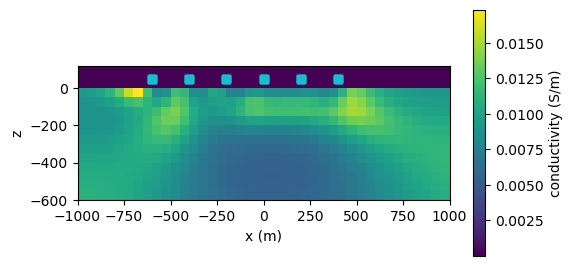

In [16]:
# Plot recovered model
plot_map = maps.ExpMap(mesh) * actMap
mopt_rec = plot_map * mopt

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

xlim = 1000*np.r_[-1, 1]
ylim= np.r_[-600, 120]

out = mesh.plot_slice(mopt_rec, normal="y", ax=ax, )#pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1), "cmap":"Spectral_r"})
cb = plt.colorbar(out[0], shrink=0.4)
cb.set_label("conductivity (S/m)")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_title("")
ax.plot(receiver_locations[:,0], np.ones_like(receiver_locations[:,0])*receiver_locations[:,2], "C9s")
ax.set_xlabel("x (m)")

In [13]:
# Predict fields and data for a synthetic model

drec = invProb.dpred
drec_obj = data.Data(survey, dobs=drec)

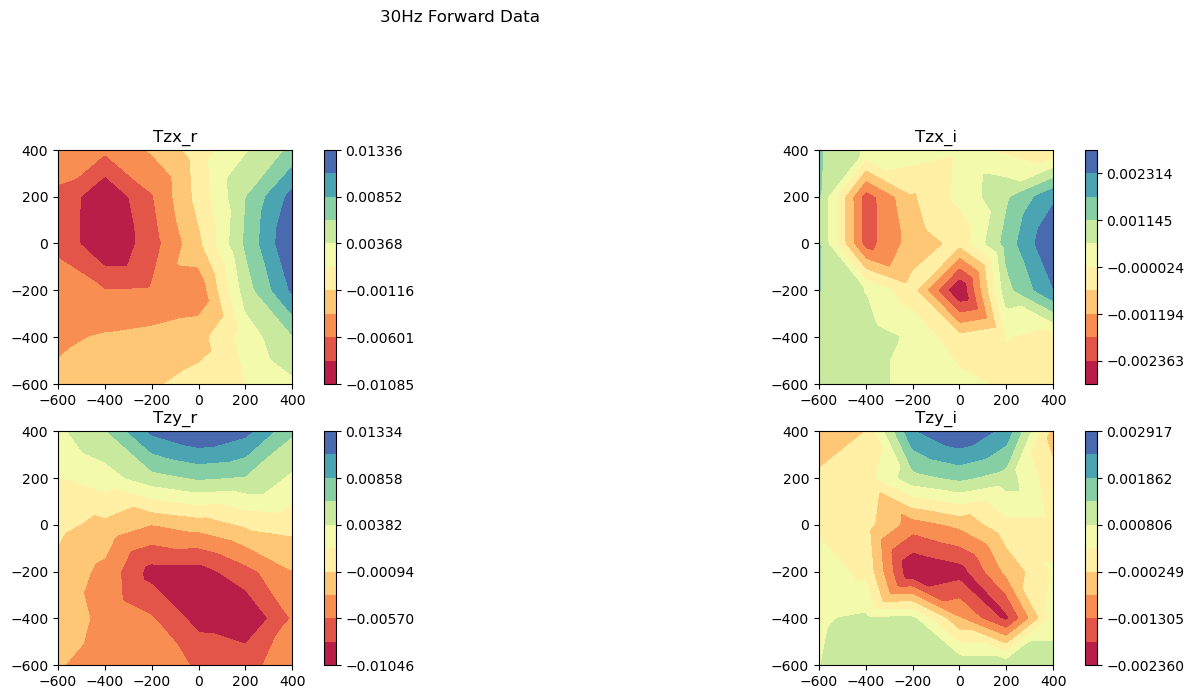

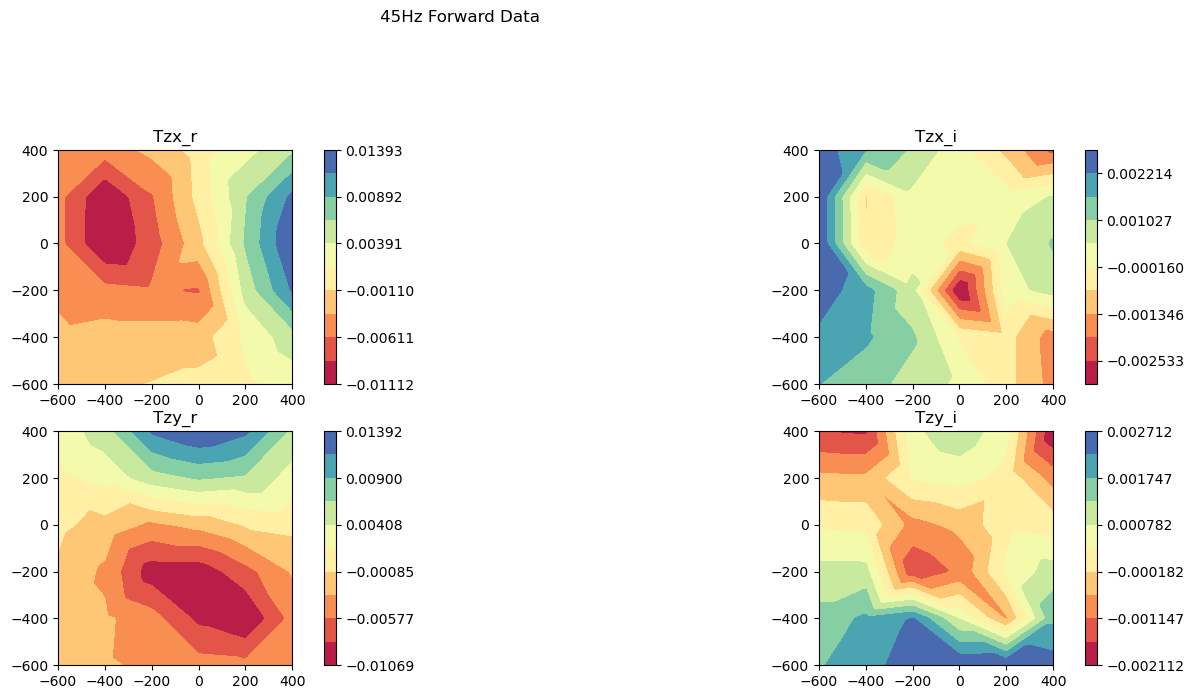

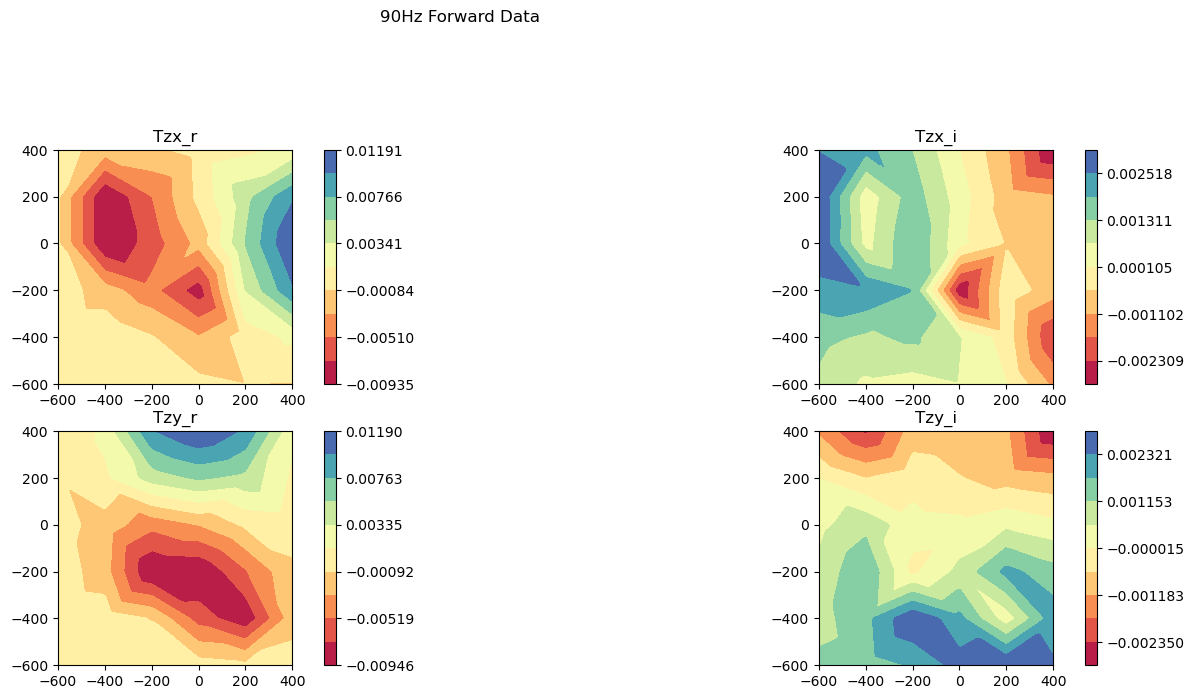

<Figure size 640x480 with 0 Axes>

In [14]:
# reshape data for plotting
num_station = receiver_locations.shape[0]
num_frequencies = len(frequencies)
#number of plots for each freq num_stations*(number of components + number of tippers). 
#here it is 36*(2+2)=144
num_sets = int(drec_obj.dobs.shape[0] / len(frequencies)) 
dplot = np.reshape(drec_obj.dobs, (num_frequencies, num_sets)) #rearrage data for plotting (num freqs,num sets)

cnt = 0

for freq in frequencies:
    cnt_comp = 0
    comps_ = ['Tzx_r', 'Tzx_i', 'Tzy_r', 'Tzy_i']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = plot2Ddata(receiver_locations, dplot[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax, contourOpts={'cmap':'Spectral'})
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(f"{freq}Hz Forward Data")    
plt.show()
plt.tight_layout()

Text(0.5, 1.0, 'Y = 0.0 SimPEG')

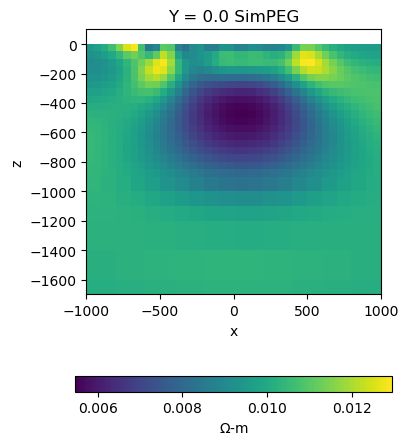

In [26]:
mrec_iteration = np.ones(mesh.nC)
mrec_iteration[active_inds] = np.exp(np.load(r"005-InversionModel-2024-04-04-01-00.npy"))
mrec_iteration[~active_inds] = np.nan
plot_ind = len(mesh.nodes_y)/2

plt.figure(figsize=(18, 18))
# plt.suptitle('Model Comparison')
ax = plt.subplot(3, 2, 1)
collect_obj = mesh.plot_slice(mrec_iteration, ax=ax, ind=int(plot_ind), grid=False, normal='Y',) #)clim=[1, 100], pcolor_opts={'cmap':'Spectral'}, title='wtf')
color_bar = plt.colorbar(collect_obj[0], shrink=0.5, orientation='horizontal', label='$\Omega$-m', pad=0.2)
ax.set_xlim([-1000, 1000])
ax.set_ylim([-1700, 100])
ax.set_aspect('equal')
ax.set_title(f"Y = {mesh.nodes_y[int(plot_ind)]} SimPEG")


In [ ]:
mesh.nodes_y[63]